# ForeGround Buster for QUBIC map

This notebook is a first try of the application of FG-Buster ([GitHub](https://github.com/fgbuster/fgbuster/tree/master/fgbuster)) algorithm on QUBIC maps. We try to separate 2 components which is the CMB signal and Dust. We apply that method for 3 different frequencies but we can also do that for 4 or 5. In this notebook we remove the noise just to see how FG buster behaves with QUBIC maps.

In [1]:
import random
import healpy as hp
import glob
from scipy.optimize import curve_fit
import pickle
from importlib import reload
import time
import scipy
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import pylab
from pylab import arange, show, cm
from astropy import units as uq
import gc

### Specific qubic modules
from qubicpack.utilities import Qubic_DataDir
from pysimulators import FitsArray
import pysm3 
import pysm3.units as u
import pysm3.utils as utils
import qubic
from qubic import QubicSkySim as qss
from qubic import fibtools as ft
from qubic import camb_interface as qc
from qubic import SpectroImLib as si
from qubic import NamasterLib as nam
from qubic import mcmc
from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator

### FGBuster functions module
from fgbuster import get_instrument, get_sky, get_observation, ilc, basic_comp_sep, harmonic_ilc, weighted_comp_sep, multi_res_comp_sep  # Predefined instrumental and sky-creation configurations
from fgbuster.visualization import corner_norm, plot_component
from fgbuster.mixingmatrix import MixingMatrix
from fgbuster.observation_helpers import _rj2cmb, _jysr2rj, get_noise_realization

# Imports needed for component separation
from fgbuster import (separation_recipes, xForecast, CMB, Dust, Synchrotron, FreeFree, PowerLaw,  # sky-fitting model
                      basic_comp_sep)  # separation routine

import ComponentSeparation
import Plots

# Widgets
import ipywidgets as widgets

reload(qss)
reload(ft)

plt.rc('figure', figsize=(16, 10))
plt.rc('font', size=15)
plt.rcParams['image.cmap'] = 'jet'

In [2]:
### Some initializations, to be replaced with specific path, or to modify in bash
os.environ['QUBIC_DATADIR'] = '/home/mathias/Bureau/qubic/qubic'
os.environ['QUBIC_DICT'] = '/home/mathias/Bureau/qubic/qubic/dicts'
global_dir = Qubic_DataDir(datafile='instrument.py', datadir=os.environ['QUBIC_DATADIR'])

In [3]:
### Qubic dictionaries for 150GHz and 220Ghz
config_150, config_220 = 'FI-150', 'FI-220'
dictfilename150 = global_dir + '/doc/FastSimulator/FastSimDemo_{}.dict'.format(config_150)
dictfilename220 = global_dir + '/doc/FastSimulator/FastSimDemo_{}.dict'.format(config_220)
d150, d220 = qubic.qubicdict.qubicDict(), qubic.qubicdict.qubicDict()
d150.read_from_file(dictfilename150)
d220.read_from_file(dictfilename220)
qub_dic = {'150': d150, '220': d220}
center = qubic.equ2gal(d220['RA_center'], d220['DEC_center'])

In [41]:
### Read some stuff
# Read dictionary chosen
d220['focal_length'] = 0.3
d220['nside'] = 256

#Define the number of reconstruction bands:
nbands = 5
d220['nf_recon'] = nbands
d220['nf_sub'] = nbands

# Coverage map

In [42]:
def coverage_func(qub_dic, nbands, is_2_band, fq, npoints):
    
    """
    Procedure that returns coverage maps either at both 150 and 220 or only 150 or 220
    
    inputs:
        qub_dic: dict, of the form {'150': qub_dic_150, '220': ...}
        nbands: int, number of subbands
        is_2_band: boolean, if user wants coverage for only 1 frequency band or for 2
        fq: int, either 150 or 220
        npoints: int, number of pointing points
    
    returns:
        q: qubic object
        cov: np.array, coverage map
    """
    
    if is_2_band == True:
        qubic_dict_150, qubic_dict_220 = qub_dic['150'], qub_dic['220']
        qubic_dict_150['nside'], qubic_dict_220['nside'] = 256, 256
        qubic_dict_150['nf_recon'] = nbands
        qubic_dict_220['nf_recon'] = nbands
        qubic_dict_150['nf_sub'] = nbands
        qubic_dict_220['nf_sub'] = nbands
        qubic_dict_150['npointings'] = npoints
        qubic_dict_220['npointings'] = npoints
        p150 = qubic.get_pointing(qubic_dict_150)
        p220 = qubic.get_pointing(qubic_dict_220)
        s150 = qubic.QubicScene(qubic_dict_150)
        s220 = qubic.QubicScene(qubic_dict_220)
        q150 = qubic.QubicMultibandInstrument(qubic_dict_150)
        q220 = qubic.QubicMultibandInstrument(qubic_dict_220)
        _, nus_edge_150, _, _, _, _ = qubic.compute_freq(150, qubic_dict_150['nf_sub'])
        _, nus_edge_220, _, _, _, _ = qubic.compute_freq(220, qubic_dict_220['nf_sub'])
        a150 = qubic.QubicMultibandAcquisition(q150, p150, s150, qubic_dict_150, nus_edge_150)
        a220 = qubic.QubicMultibandAcquisition(q220, p220, s220, qubic_dict_220, nus_edge_220)
        cov1 = a150.get_coverage()
        cov2 = a220.get_coverage()
        a150 = 0
        a220 = 0
        cov1 = np.sum(cov1, axis=0)
        cov2 = np.sum(cov2, axis=0)
        cov1 /= np.max(cov1)
        cov2 /= np.max(cov2)
        return q150, q220, cov1, cov2
    else:
        gc.collect()
        qubic_dict = qub_dic[str(fq)]
        qubic_dict['nside'] = 256
        qubic_dict['nf_recon'] = nbands
        qubic_dict['nf_sub'] = nbands
        qubic_dict['npointings'] = npoints
        p = qubic.get_pointing(qubic_dict)
        s = qubic.QubicScene(qubic_dict)
        q = qubic.QubicMultibandInstrument(qubic_dict)
        _, nus_edge, _, _, _, _ = qubic.compute_freq(fq, qubic_dict['nf_sub'])
        a = qubic.QubicMultibandAcquisition(q, p, s, qubic_dict, nus_edge)
        cov = a.get_coverage()
        a = 0
        cov = np.sum(cov, axis=0)
        cov /= np.max(cov)
        return q, cov

In [43]:
npix = 12 * d220['nside'] ** 2
Nf = int(d220['nf_sub'])
band = d220['filter_nu'] / 1e9
filter_relative_bandwidth = d220['filter_relative_bandwidth']
a, nus_edge, nus_in, d, e, Nbbands_in = qubic.compute_freq(band, Nf, filter_relative_bandwidth)

We change the map coverage to take into account edge effects so we have to increase number of pointing.

In [7]:
qub_dic['150']['dtheta'] = 30

In [44]:
### Example of how it works ...
#q150, cov150 = coverage_func(qub_dic, nbands, False, 150, 3000)

cov = pickle.load(open('/home/mathias/Bureau/coverage_dtheta_40_pointing_6000.pkl', 'rb'))
cov150 = cov['coverage']

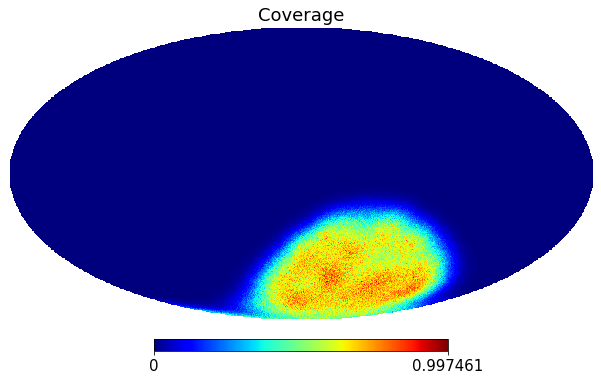

In [45]:
hp.mollview(cov150, title = 'Coverage')

In [46]:
okpix_inside = (cov150 > (0.5*np.max(cov150)))
cov_qubic = np.loadtxt('mask_fgbuster')
okpix_qubic = cov_qubic != 0

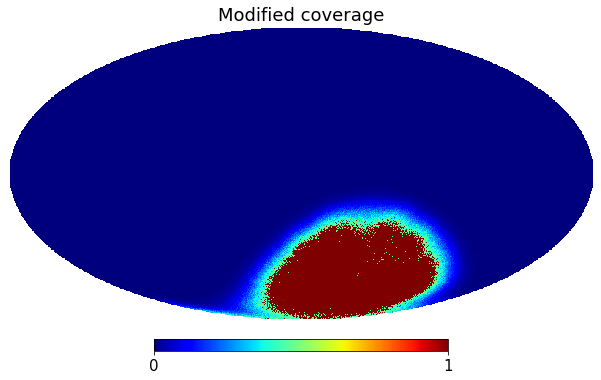

In [47]:
maps = cov150.copy()
maps[okpix_inside] = 1
hp.mollview(maps, title = 'Modified coverage')

Here we define all frequencies, FWHM and we decide the noise level and if we integrate into band.We put also all maps at the same resolutions

In [48]:
'''
if nbands == 3 :
    freqs = [136.984337, 148.954079, 161.969742]
    fwhmdegs = [0.42999269, 0.39543908, 0.36366215]
elif nbands == 4 :
    freqs = [135.50540829,    144.29216391,    153.6486907 ,    163.61193508]
    fwhmdegs = [0.43468571,    0.40821527,    0.38335676,    0.36001202]
elif nbands == 5 :
    freqs = [134.63280448,    141.57278853,    148.8705114 ,    156.54441361,    164.61388627]
    fwhmdegs = [0.43750306,    0.41605639,    0.39566106,    0.37626551,    0.35782075]
else :
    raise TypeError('Incorrect frequency number')
'''
  

if nbands == 3 :
    freqs = [200.9103609 , 218.46598318, 237.55562228]
    fwhmdegs = [0.42999269, 0.39543908, 0.36366215]
elif nbands == 4 :
    freqs = [198.74126549, 211.62850707, 225.35141303, 239.96417145]
    fwhmdegs = [0.43468571,    0.40821527,    0.38335676,    0.36001202]
elif nbands == 5 :
    freqs = [197.46144657, 207.64008985, 218.34341672, 229.59847329, 241.43369986]
    fwhmdegs = [0.43750306,    0.41605639,    0.39566106,    0.37626551,    0.35782075]
else :
    raise TypeError('Incorrect frequency number')  
   
fwhm_final = np.max(fwhmdegs) + 1e-10    # All maps will have this resolution

verbose = False
integration_into_band = True
nunu_correlation = True
FWHMdeg = fwhmdegs
spatial_noise = True
nyears = 4e20

In [49]:
okpix = (cov150 > (0.1*np.max(cov150)))

We call here **QubicSkySim** code to obtain CMB map, Dsut map and CMB + Dust map.

In [50]:
seed = 42
sky_config = {'dust': 'd0', 'cmb': seed}
Qubic_sky_150 = qss.Qubic_sky(sky_config, d220)


CMBdust, CMBdust_noiseless, CMBdust_noise, P = Qubic_sky_150.get_partial_sky_maps_withnoise(coverage=cov150,
                                       Nyears=nyears, verbose=verbose, FWHMdeg=FWHMdeg, seed = 42,
                                       spatial_noise=spatial_noise,
                                       nunu_correlation=nunu_correlation,
                                       integrate_into_band=integration_into_band
                                            )
CMBdust = np.transpose(CMBdust, (0, 2, 1))
CMBdust_noiseless = np.transpose(CMBdust_noiseless, (0, 2, 1))
CMBdust_noise = np.transpose(CMBdust_noise, (0, 2, 1))

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/lGrzSECxrW
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

doing band 0 192.5 202.4228931334765
doing band 1 202.4228931334765 212.8572865689706
doing band 2 212.8572865689706 223.82954686666244
doing band 3 223.82954686666244 235.36739971690844
doing band 4 235.36739971690844 247.49999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI220_nfsub_5.pkl'>


In [51]:
sky_config = {'cmb': seed}
Qubic_sky_150_cmb = qss.Qubic_sky(sky_config, d220)


cmb, CMB_noiseless, CMB_noise, _ = Qubic_sky_150_cmb.get_partial_sky_maps_withnoise(coverage=cov150,
                                       Nyears=nyears, verbose=verbose, FWHMdeg=FWHMdeg, seed = 42,
                                       spatial_noise=spatial_noise,
                                       nunu_correlation=nunu_correlation,
                                       integrate_into_band=integration_into_band)

cmb = np.transpose(cmb, (0, 2, 1))
CMB_noiseless = np.transpose(CMB_noiseless, (0, 2, 1))
CMB_noise = np.transpose(CMB_noise, (0, 2, 1))

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/oScCMlQQU7
  warnings.warn(f"Access data from {full_path}")


doing band 0 192.5 202.4228931334765
doing band 1 202.4228931334765 212.8572865689706
doing band 2 212.8572865689706 223.82954686666244
doing band 3 223.82954686666244 235.36739971690844
doing band 4 235.36739971690844 247.49999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI220_nfsub_5.pkl'>


In [52]:
sky_config = {'dust': 'd0'}
Qubic_sky_150_dust = qss.Qubic_sky(sky_config, d220)

dust, dust_noiseless, dust_noise, _ = Qubic_sky_150_dust.get_partial_sky_maps_withnoise(coverage=cov150,
                                       Nyears=nyears, verbose=verbose, FWHMdeg=FWHMdeg, seed = 42,
                                       spatial_noise=spatial_noise,
                                       nunu_correlation=nunu_correlation,
                                       integrate_into_band=integration_into_band)
dust = np.transpose(dust, (0, 2, 1))
dust_noiseless = np.transpose(dust_noiseless, (0, 2, 1))
dust_noise = np.transpose(dust_noise, (0, 2, 1))

doing band 0 192.5 202.4228931334765
doing band 1 202.4228931334765 212.8572865689706
doing band 2 212.8572865689706 223.82954686666244
doing band 3 223.82954686666244 235.36739971690844
doing band 4 235.36739971690844 247.49999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI220_nfsub_5.pkl'>


# Input maps

Here we show all maps for each components.

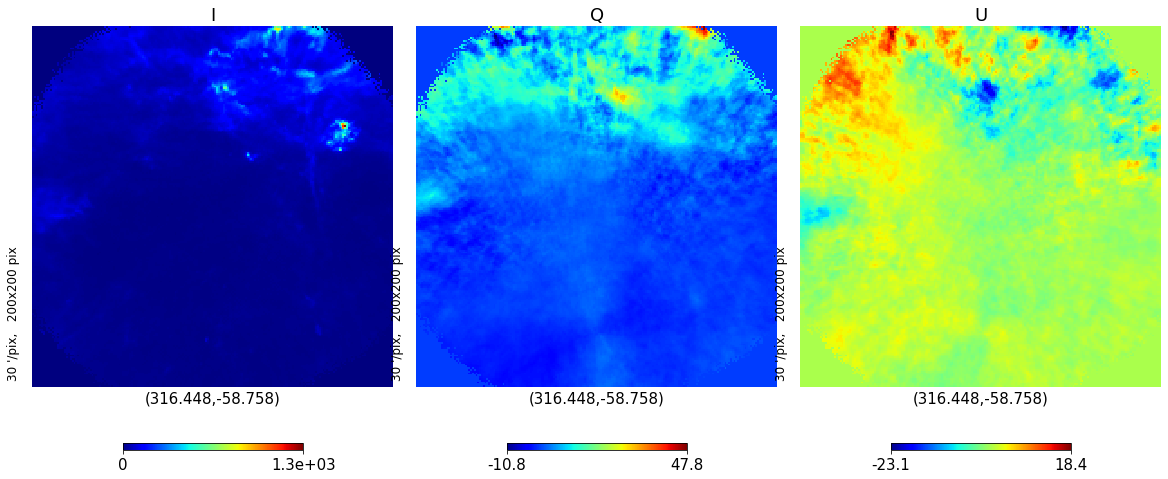

In [53]:
plt.rc('figure', figsize=(16, 10))
hp.gnomview(dust[0, 0, :], rot = center, reso = 30, sub = (1, 3, 1), title = 'I')
hp.gnomview(dust[0, 1, :], rot = center, reso = 30, sub = (1, 3, 2), title = 'Q')
hp.gnomview(dust[0, 2, :], rot = center, reso = 30, sub = (1, 3, 3), title = 'U')
plt.show()

## 136.98 GHz

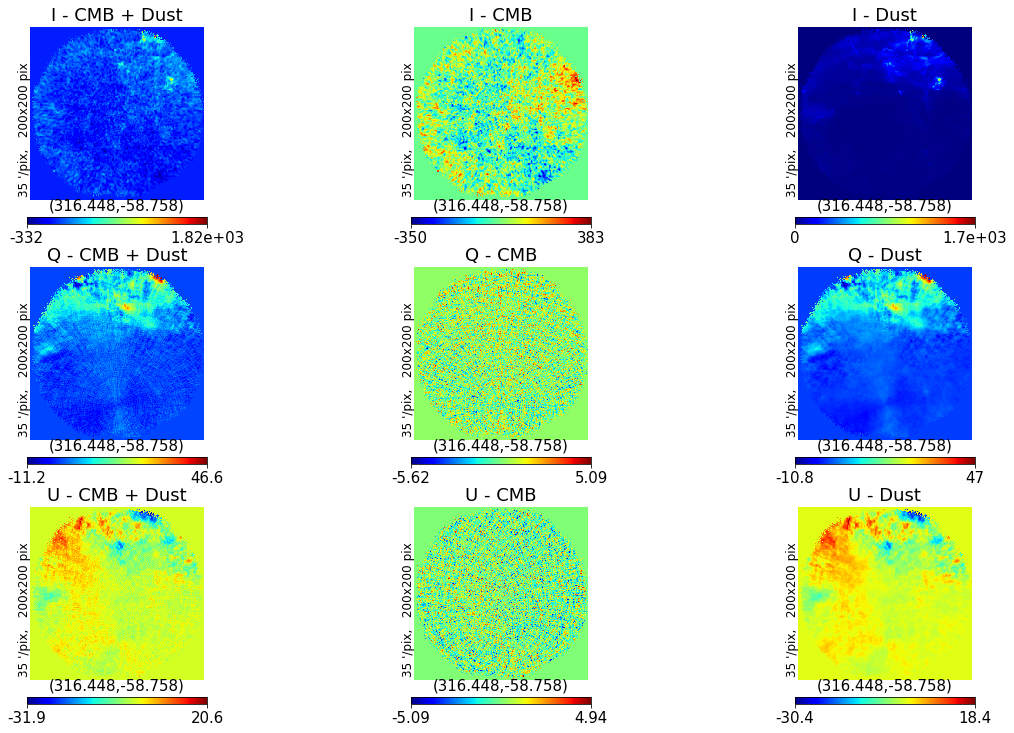

In [54]:
plt.figure()
Plots.Plots.all_components([CMBdust, cmb, dust], 0, center, 35, 
                           ['CMB + Dust', 'CMB', 'Dust'], nb_component = 3)
plt.show()

## 148.95 GHz

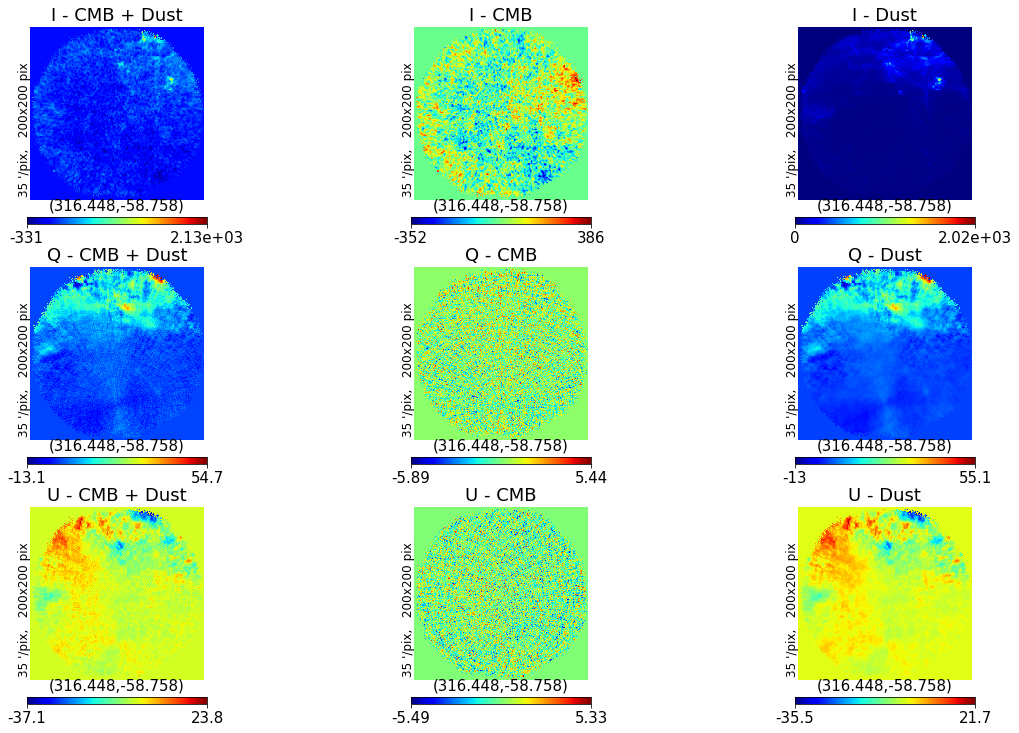

In [55]:
plt.figure()
Plots.Plots.all_components([CMBdust, cmb, dust], 1, center, 35, ['CMB + Dust', 'CMB', 'Dust'])
plt.show()

## 161.96 GHz

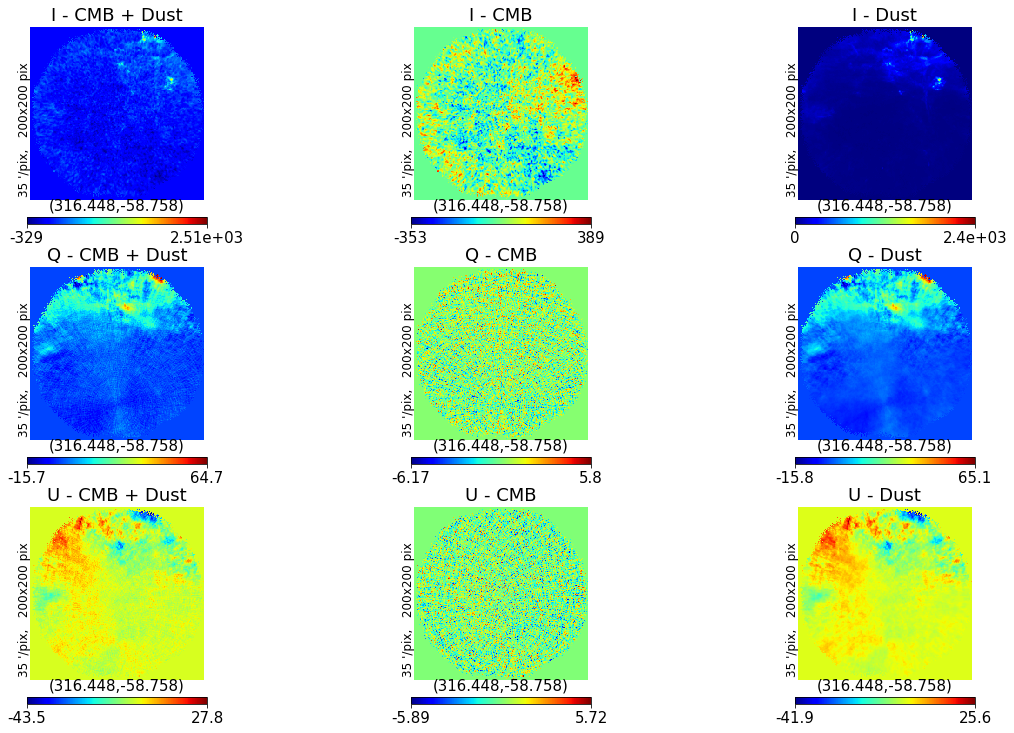

In [56]:
plt.figure()
Plots.Plots.all_components([CMBdust, cmb, dust], 2, center, 35, ['CMB + Dust', 'CMB', 'Dust'])
plt.show()

We put all maps at the same resolution to compare them.

In [57]:
dust_same_resol, tab_fwhm, delta_fwhm = ComponentSeparation.same_resol(dust_noiseless, fwhmdegs, 
                                                                fwhm_target = fwhm_final, verbose=True)

0.4375030601 0.43750306
Sub 0: Going from 0.437503060000 to 0.437503060100
   -> Convolution with  0.00
Sub 1: Going from 0.416056390000 to 0.437503060100
   -> Convolution with  0.14
Sub 2: Going from 0.395661060000 to 0.437503060100
   -> Convolution with  0.19
Sub 3: Going from 0.376265510000 to 0.437503060100
   -> Convolution with  0.22
Sub 4: Going from 0.357820750000 to 0.437503060100
   -> Convolution with  0.25


In [58]:
cmb_same_resol, tab_fwhm, delta_fwhm = ComponentSeparation.same_resol(CMB_noiseless, fwhmdegs, 
                                                                fwhm_target = fwhm_final, verbose=True)

0.4375030601 0.43750306
Sub 0: Going from 0.437503060000 to 0.437503060100
   -> Convolution with  0.00
Sub 1: Going from 0.416056390000 to 0.437503060100
   -> Convolution with  0.14
Sub 2: Going from 0.395661060000 to 0.437503060100
   -> Convolution with  0.19
Sub 3: Going from 0.376265510000 to 0.437503060100
   -> Convolution with  0.22
Sub 4: Going from 0.357820750000 to 0.437503060100
   -> Convolution with  0.25


Here we check if **same_resol** from **ComponentSeparation.py** put all maps at the same resolution, we expect a big edge effects due to abrupt jumps to zero. That's why we have to take smaller area in FG-Buster.

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/projaxes.py:1184: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/projaxes.py:1185: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


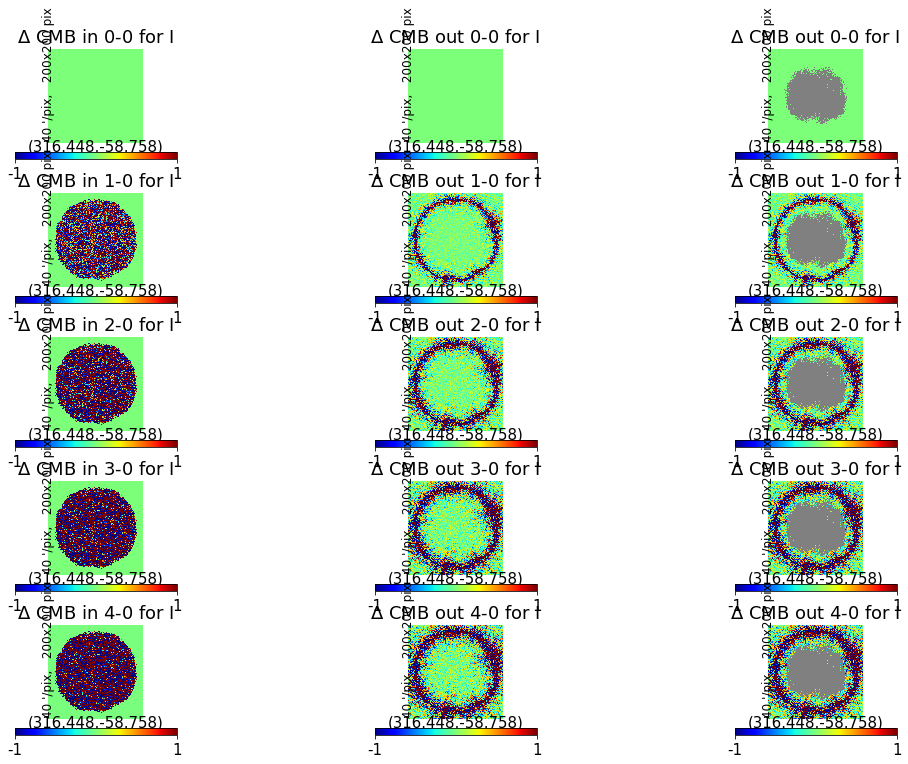

In [59]:
stk = ['I','Q','U']
reso = 40
jstk = 0
maps = cmb_same_resol.copy()
maps[:, :, okpix_inside] = np.nan
plt.rc('figure', figsize=(22, 10))
itest = 0
plt.figure(figsize = (25, 10))
for i in range(len(freqs)):
    hp.gnomview(CMB_noiseless[i,jstk,:]-CMB_noiseless[itest,jstk,:], rot=center, reso=reso,
                sub=(nbands,len(freqs),len(freqs)*i+1), min=-1, max=1,
                title='$\Delta$ CMB in {}-{} for {}'.format(i,itest,stk[jstk]))
    hp.gnomview(cmb_same_resol[i,jstk,:]-cmb_same_resol[itest,jstk,:], rot=center, reso=reso,
                sub=(nbands,len(freqs),len(freqs)*i+2), min=-1, max=1,
                title='$\Delta$ CMB out {}-{} for {}'.format(i,itest,stk[jstk]))
    hp.gnomview(maps[i,jstk,:]-maps[itest,jstk,:], rot=center, reso=reso,
                sub=(nbands,len(freqs),len(freqs)*i+3), min=-1, max=1,
                title='$\Delta$ CMB out {}-{} for {}'.format(i,itest,stk[jstk]))

plt.show()

This plot show different coverage, in green the initial coverage and in red a correction to take into account the bad convolution at the edges.

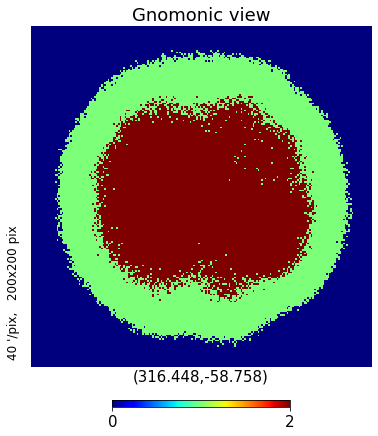

In [60]:
maps = np.zeros(12*256**2)
maps[okpix] = 1
maps[okpix_inside] = 2

hp.gnomview(maps, rot = center, reso = reso)

We call here the **fg_buster** function from **ComponentSeparation.py** to separe components. The function needs the map with different components, the frequency, the resolution of maps. The last twos parameter are here to have a better result. **okpix** is an argument which define which pixels are seen by FG-Buster and **Stokesparameter** decide if we want to separate the temperature and the polarisation during separation.

In [61]:
okpix = cov150 != 0

In [62]:
Stkp = 'IQU'
okpix_maps = okpix_inside.copy()
array_est_fg = np.zeros(((2, nbands, 3, 12*d150['nside']**2)))

for i in range(nbands) :
    R = ComponentSeparation.CompSep(d220).fg_buster(CMBdust, 
        [CMB(), Dust(freqs[i], temp = 20.)], freq = freqs, fwhmdeg = fwhmdegs, 
                                                target = fwhm_final, okpix = okpix_maps, Stokesparameter = Stkp)

    print(' \n beta_d = {:.5f} \n'.format(R.x[0]))

    array_est_fg[0, i, :, okpix_maps] = R.s[0, :, :].T
    array_est_fg[1, i, :, okpix_maps] = R.s[1, :, :].T

0.4375030601 0.43750306
Sub 0: Going from 0.437503060000 to 0.437503060100
   -> Convolution with  0.00
Sub 1: Going from 0.416056390000 to 0.437503060100
   -> Convolution with  0.14
Sub 2: Going from 0.395661060000 to 0.437503060100
   -> Convolution with  0.19
Sub 3: Going from 0.376265510000 to 0.437503060100
   -> Convolution with  0.22
Sub 4: Going from 0.357820750000 to 0.437503060100
   -> Convolution with  0.25
 
 beta_d = 1.53834 

0.4375030601 0.43750306
Sub 0: Going from 0.437503060000 to 0.437503060100
   -> Convolution with  0.00
Sub 1: Going from 0.416056390000 to 0.437503060100
   -> Convolution with  0.14
Sub 2: Going from 0.395661060000 to 0.437503060100
   -> Convolution with  0.19
Sub 3: Going from 0.376265510000 to 0.437503060100
   -> Convolution with  0.22
Sub 4: Going from 0.357820750000 to 0.437503060100
   -> Convolution with  0.25
 
 beta_d = 1.53834 

0.4375030601 0.43750306
Sub 0: Going from 0.437503060000 to 0.437503060100
   -> Convolution with  0.00
Sub 

In [63]:
CMBdust[:, :, ~okpix_qubic] = 0
array_est_fg[:, :, :, ~okpix_qubic] = 0

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/projaxes.py:209: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  app.launch_new_instance()


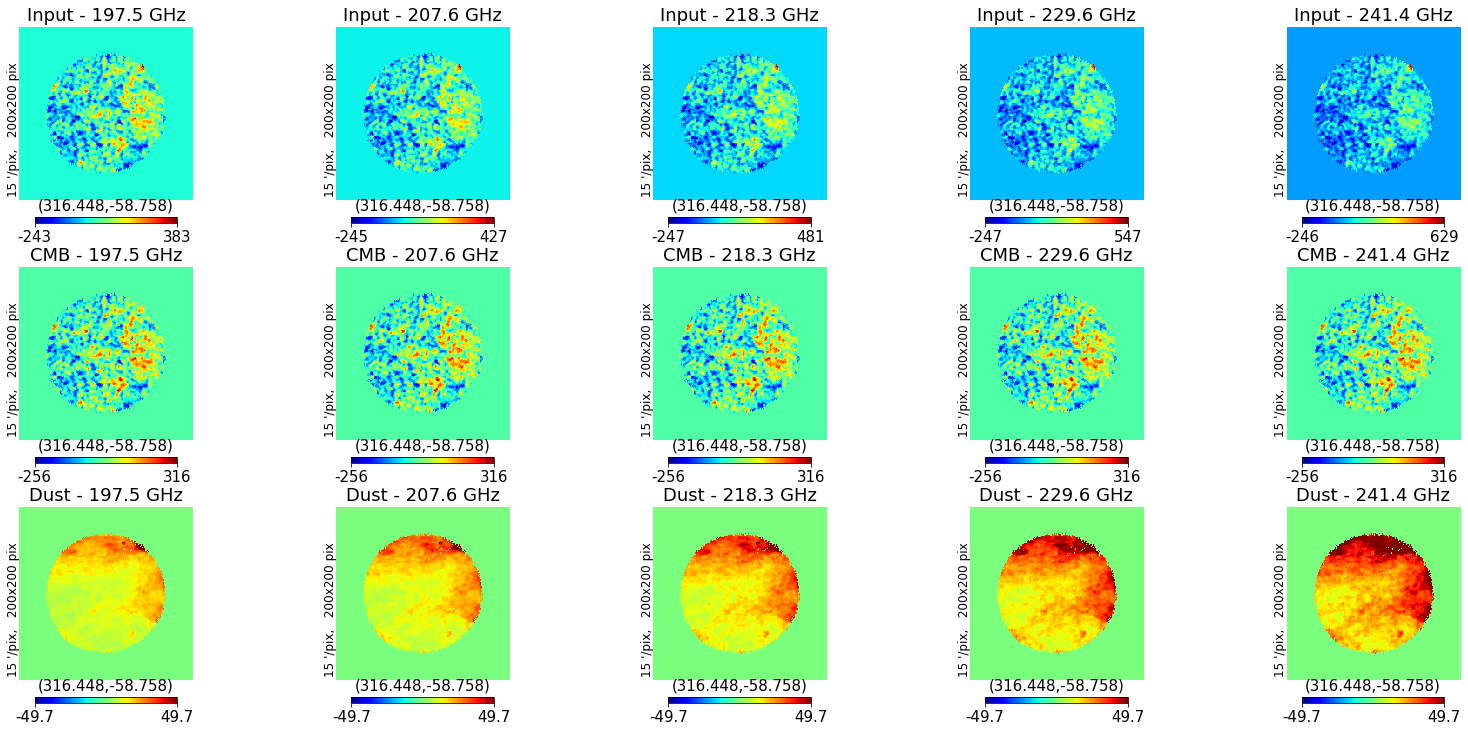

In [64]:
istk = 0
nsig = 20
sig_dust = np.std(array_est_fg[1, 0, istk, :])

plt.figure()
for i in range(nbands) :
    
    hp.gnomview(CMBdust[i, istk, :], rot = center, reso = 15, 
                title = 'Input - {0:.1f} GHz'.format(freqs[i]), sub = (3, 5, i+1))
    
    hp.gnomview(array_est_fg[0, i, istk, :], rot = center, reso = 15, 
                title = 'CMB - {0:.1f} GHz'.format(freqs[i]), sub = (3, 5, i+6))
    hp.gnomview(array_est_fg[1, i, istk, :], rot = center, reso = 15, min = - nsig * sig_dust, max = nsig * sig_dust,
                title = 'Dust - {0:.1f} GHz'.format(freqs[i]), sub = (3, 5, i+11))
    
plt.tight_layout()
plt.show()

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  app.launch_new_instance()


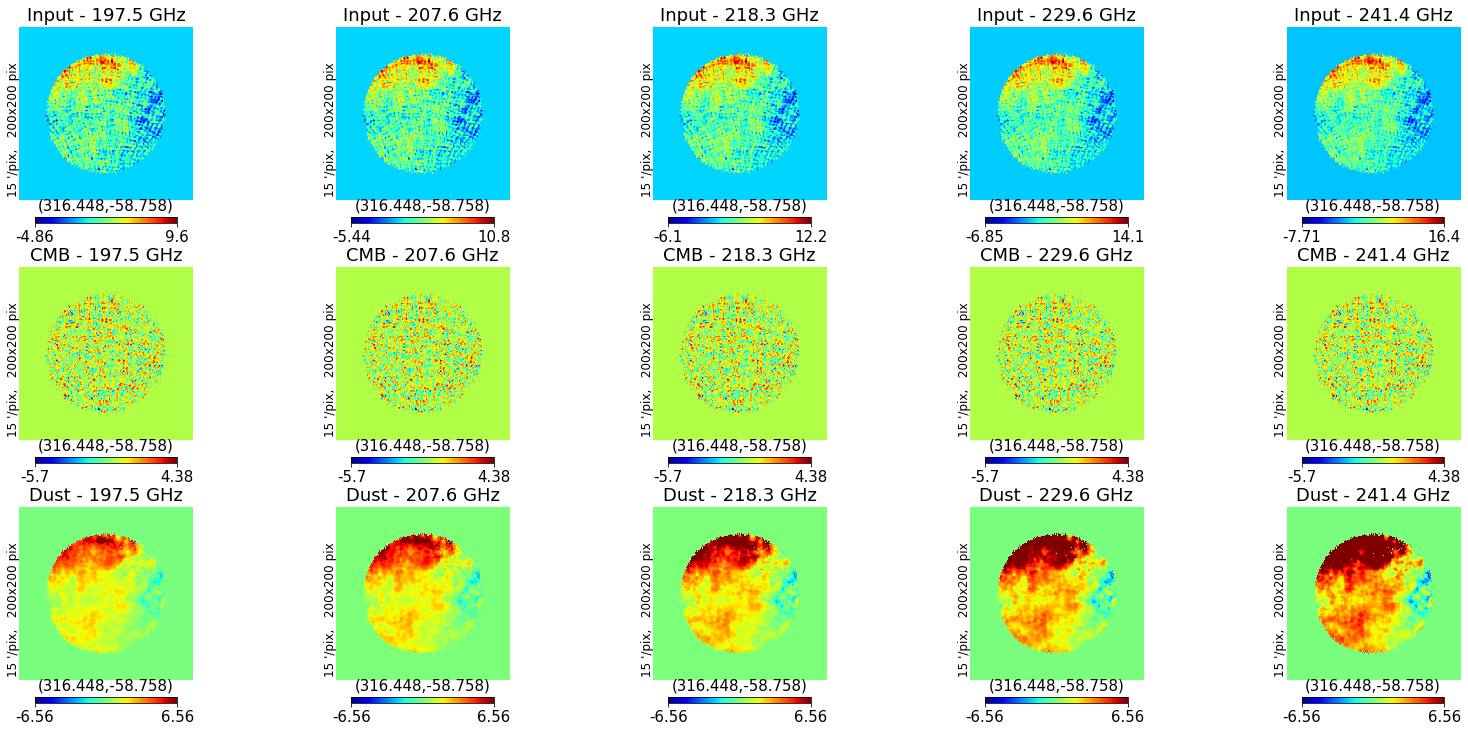

In [65]:
istk = 1
nsig = 20
sig_dust = np.std(array_est_fg[1, 0, istk, :])

plt.figure()
for i in range(nbands) :
    
    hp.gnomview(CMBdust[i, istk, :], rot = center, reso = 15, 
                title = 'Input - {0:.1f} GHz'.format(freqs[i]), sub = (3, 5, i+1))
    
    hp.gnomview(array_est_fg[0, i, istk, :], rot = center, reso = 15, 
                title = 'CMB - {0:.1f} GHz'.format(freqs[i]), sub = (3, 5, i+6))
    hp.gnomview(array_est_fg[1, i, istk, :], rot = center, reso = 15, min = - nsig * sig_dust, max = nsig * sig_dust,
                title = 'Dust - {0:.1f} GHz'.format(freqs[i]), sub = (3, 5, i+11))

plt.tight_layout()
plt.show()

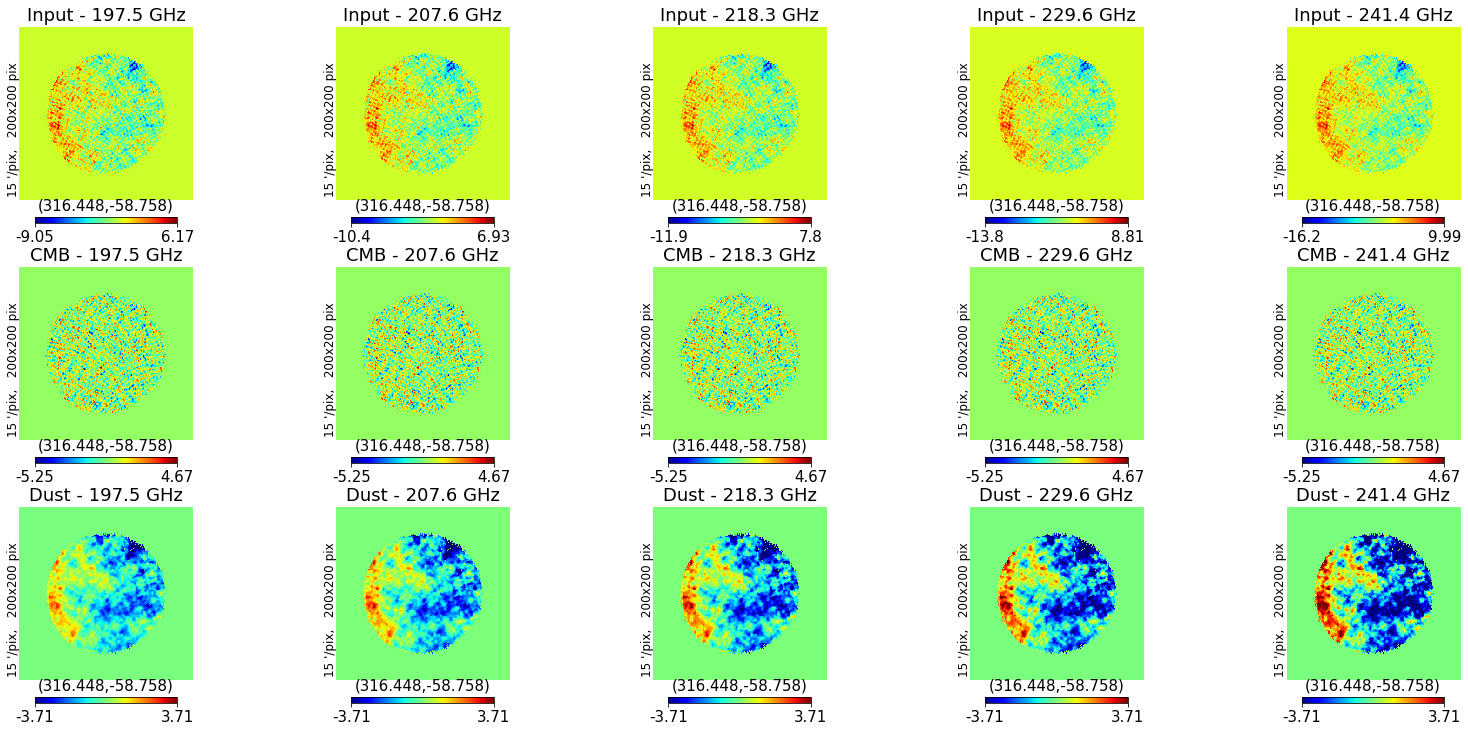

In [66]:
istk = 2
nsig = 20
sig_dust = np.std(array_est_fg[1, 0, istk, :])
for i in range(nbands) :
    
    hp.gnomview(CMBdust[i, istk, :], rot = center, reso = 15, 
                title = 'Input - {0:.1f} GHz'.format(freqs[i]), sub = (3, 5, i+1))
    
    hp.gnomview(array_est_fg[0, i, istk, :], rot = center, reso = 15, 
                title = 'CMB - {0:.1f} GHz'.format(freqs[i]), sub = (3, 5, i+6))
    hp.gnomview(array_est_fg[1, i, istk, :], rot = center, reso = 15, min = - nsig * sig_dust, max = nsig * sig_dust,
                title = 'Dust - {0:.1f} GHz'.format(freqs[i]), sub = (3, 5, i+11))

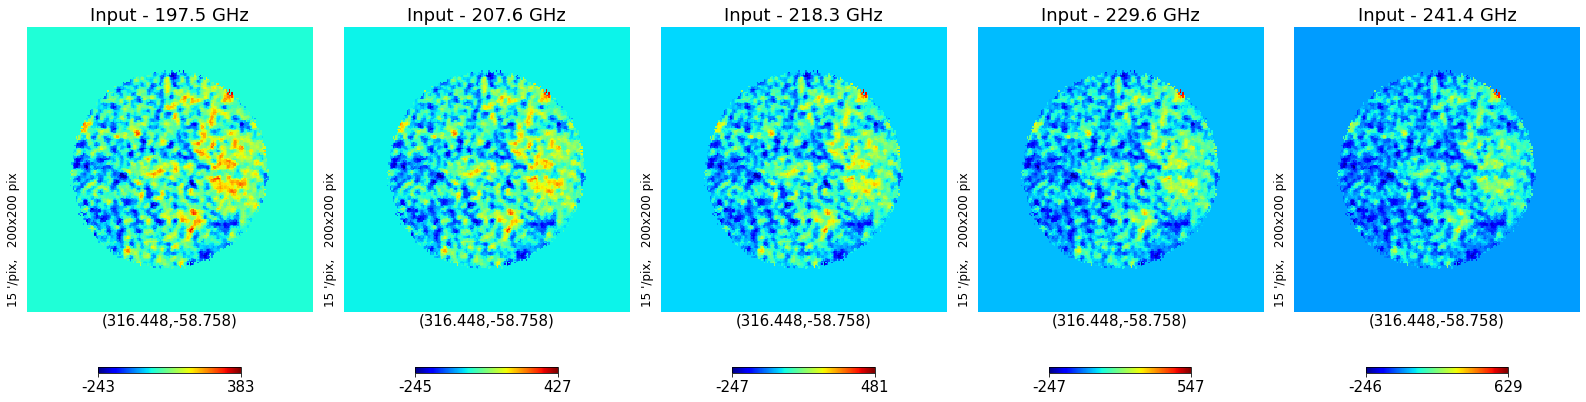

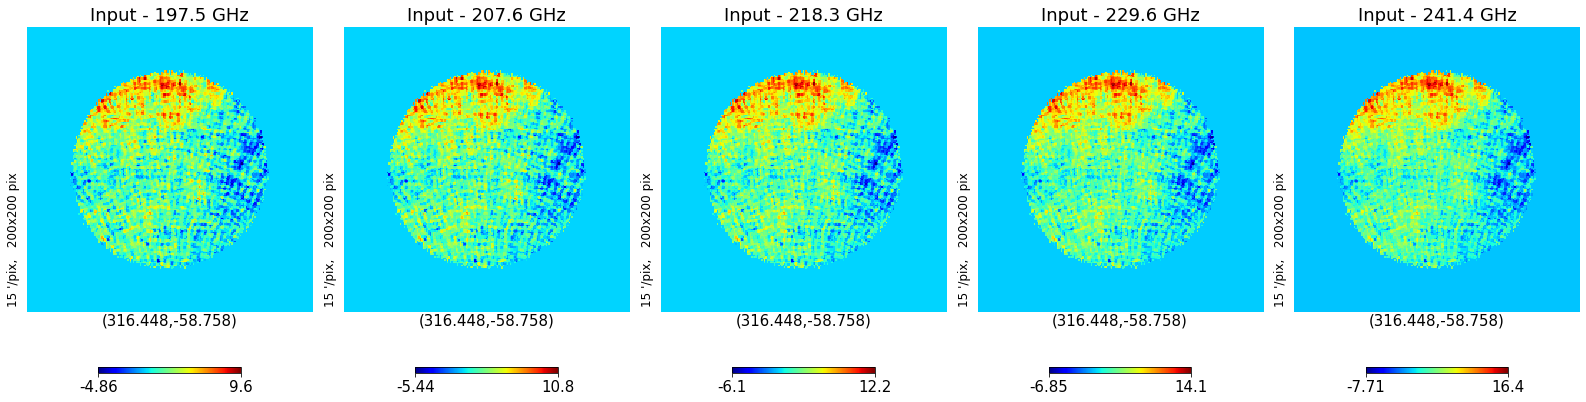

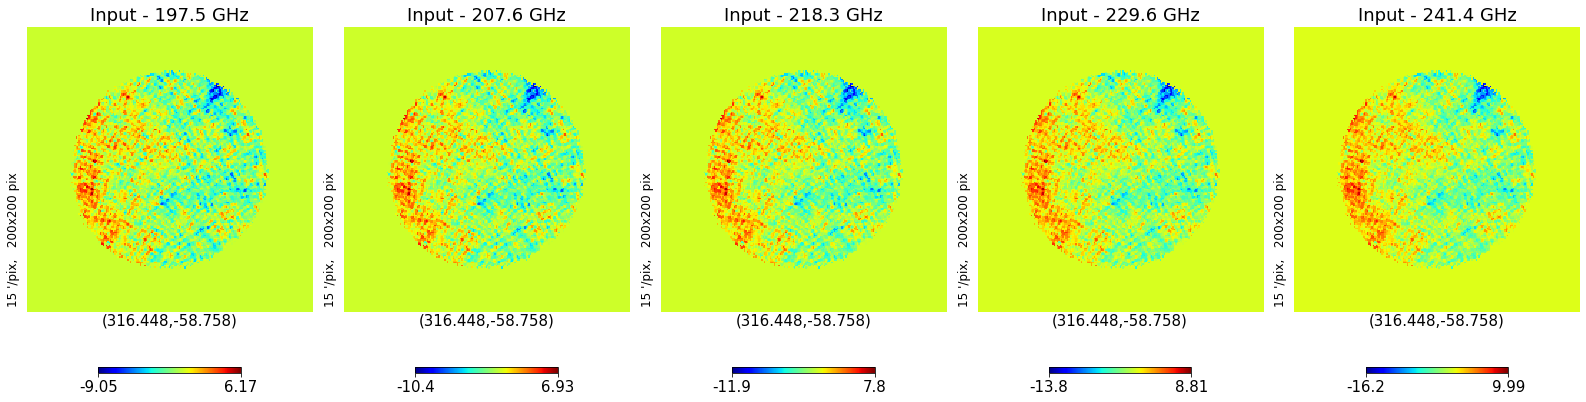

In [67]:
istk = 0
nsig = 20
plt.figure()
for i in range(nbands) :
    hp.gnomview(CMBdust[i, 0, :], rot = center, reso = 15, 
                title = 'Input - {0:.1f} GHz'.format(freqs[i]), sub = (1, 5, i+1))
plt.show()
plt.figure()
for i in range(nbands) :
    hp.gnomview(CMBdust[i, 1, :], rot = center, reso = 15, 
                title = 'Input - {0:.1f} GHz'.format(freqs[i]), sub = (1, 5, i+1))
plt.show()
plt.figure()
for i in range(nbands) :
    hp.gnomview(CMBdust[i, 2, :], rot = center, reso = 15, 
                title = 'Input - {0:.1f} GHz'.format(freqs[i]), sub = (1, 5, i+1))
plt.show() 

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # This is added back by InteractiveShellApp.init_path()


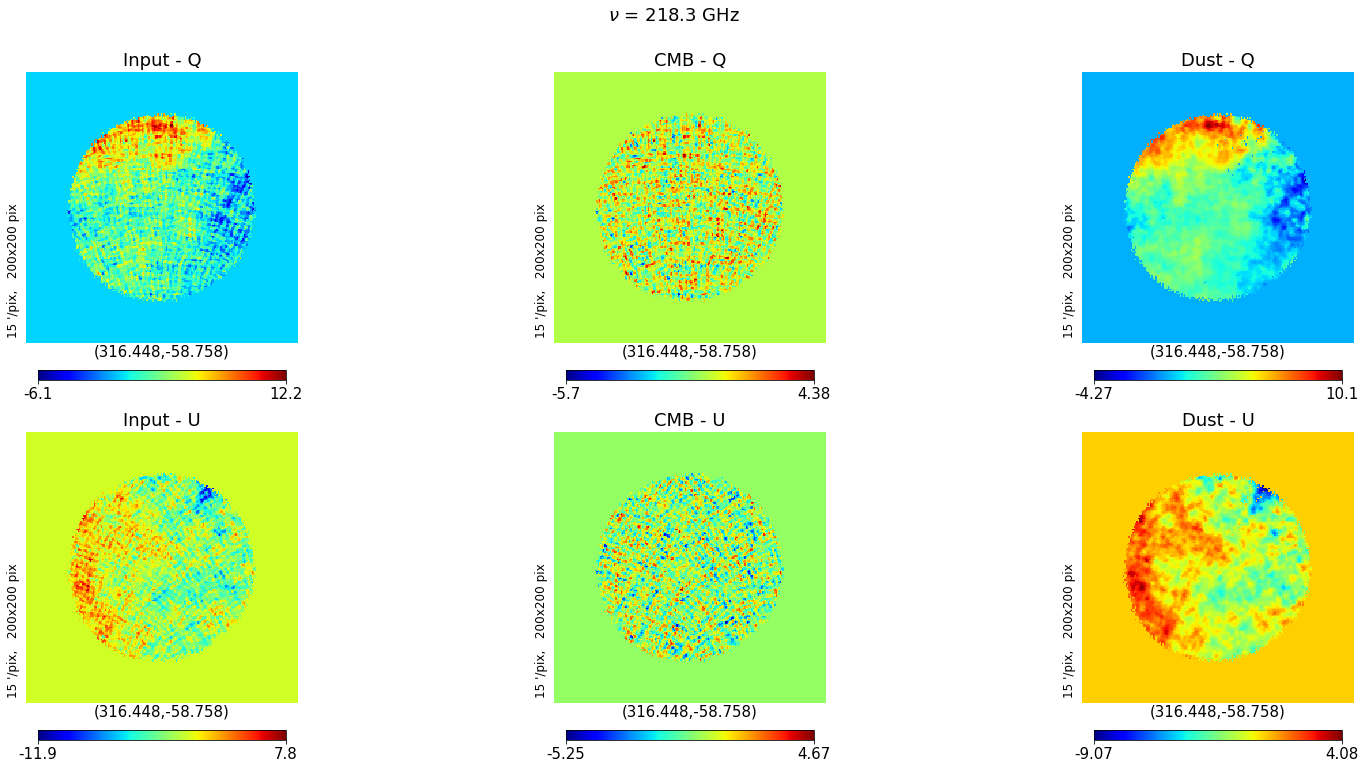

In [68]:
i_f = 2

plt.figure()
hp.gnomview(CMBdust[i_f, 1, :], rot = center, reso = 15, sub = (2, 3, 1), title = 'Input - Q')
hp.gnomview(array_est_fg[0, i_f, 1, :], rot = center, reso = 15, sub = (2, 3, 2), title = 'CMB - Q')
hp.gnomview(array_est_fg[1, i_f, 1, :], rot = center, reso = 15, sub = (2, 3, 3), title = 'Dust - Q')
hp.gnomview(CMBdust[i_f, 2, :], rot = center, reso = 15, sub = (2, 3, 4), title = 'Input - U')
hp.gnomview(array_est_fg[0, i_f, 2, :], rot = center, reso = 15, sub = (2, 3, 5), title = 'CMB - U')
hp.gnomview(array_est_fg[1, i_f, 2, :], rot = center, reso = 15, sub = (2, 3, 6), title = 'Dust - U')
plt.suptitle(r'$\nu$ = {0:.1f} GHz'.format(freqs[i_f]), y = 1.05)
plt.tight_layout()
plt.show()

In [69]:
cmbdust_same_resol, tab_fwhm, delta_fwhm = ComponentSeparation.same_resol(CMBdust, fwhmdegs, 
                                                                fwhm_target = fwhm_final, verbose=True)

0.4375030601 0.43750306
Sub 0: Going from 0.437503060000 to 0.437503060100
   -> Convolution with  0.00
Sub 1: Going from 0.416056390000 to 0.437503060100
   -> Convolution with  0.14
Sub 2: Going from 0.395661060000 to 0.437503060100
   -> Convolution with  0.19
Sub 3: Going from 0.376265510000 to 0.437503060100
   -> Convolution with  0.22
Sub 4: Going from 0.357820750000 to 0.437503060100
   -> Convolution with  0.25


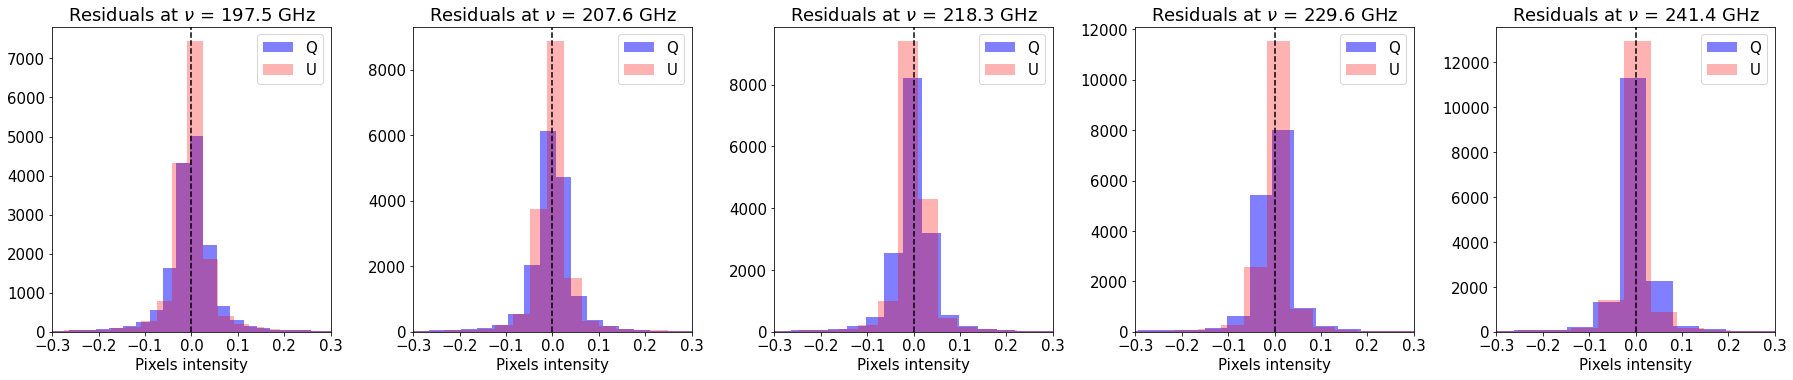

In [72]:
plt.figure(figsize = (25, 10))
for i_f in range(5) :
    plt.subplot(2, 5, i_f+1)
    res_Q = cmbdust_same_resol[i_f, 1, okpix_qubic] - array_est_fg[0, i_f, 1, okpix_qubic] - array_est_fg[1, i_f, 1, okpix_qubic]
    res_U = cmbdust_same_resol[i_f, 2, okpix_qubic] - array_est_fg[0, i_f, 2, okpix_qubic] - array_est_fg[1, i_f, 2, okpix_qubic]

    plt.hist(res_Q, bins = 300, alpha = 0.5, color = 'blue', label = 'Q')
    plt.hist(res_U, bins = 300, alpha = 0.3, color = 'red', label = 'U')
    plt.axvline(0, ls = '--', color = 'black')


    plt.tight_layout()
    plt.xlim(-0.3, 0.3)
    plt.xlabel('Pixels intensity')
    plt.legend(loc = 'upper right')
    plt.title(r'Residuals at $\nu$ = {0:.1f} GHz'.format(freqs[i_f]))
plt.show()

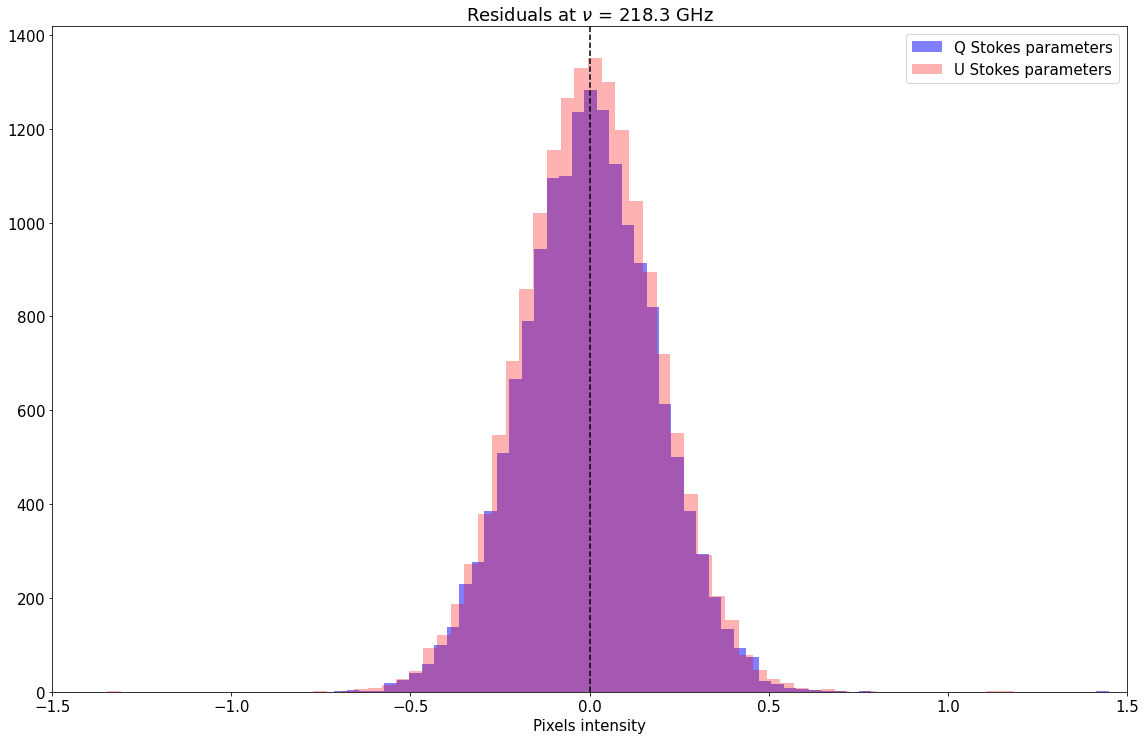

In [71]:
i_f = 2

plt.figure(figsize = (16, 10))
res_Q = CMBdust[i_f, 1, okpix_qubic] - array_est_fg[0, i_f, 1, okpix_qubic] - array_est_fg[1, i_f, 1, okpix_qubic]
res_U = CMBdust[i_f, 2, okpix_qubic] - array_est_fg[0, i_f, 2, okpix_qubic] - array_est_fg[1, i_f, 2, okpix_qubic]

plt.hist(res_Q, bins = 300, alpha = 0.5, color = 'blue', label = 'Q Stokes parameters')
plt.hist(res_U, bins = 300, alpha = 0.3, color = 'red', label = 'U Stokes parameters')
plt.axvline(0, ls = '--', color = 'black')

plt.tight_layout()
plt.xlim(-1.5, 1.5)
plt.xlabel('Pixels intensity')
plt.legend(loc = 'upper right')
plt.title(r'Residuals at $\nu$ = {0:.1f} GHz'.format(freqs[i_f]))
plt.show()

To have an idea of the reconstruction quality, we show the $\beta_d$ and dust temperature which must be respectively $\beta_d = 1.54$.

In [233]:
print(' \n beta_d = {:.5f} \n'.format(R.x[0]))

 
 beta_d = 1.53554 



In [234]:
reload(ComponentSeparation)

<module 'ComponentSeparation' from '/home/mathias/Bureau/ComponentSeparation.py'>

We convert the R dictionary to arrays. The form of the final array is (Ncomp, Nfreq, Stokes, Npix) where Ncomp = 0 for the CMB, Ncomp = 1 for the dust and Ncomp = 2 for the synchrotron effect.

In [235]:
cmb_same_resol_bis = cmb_same_resol.copy()
cmb_same_resol[:, :, ~okpix_qubic] = 0
dust_same_resol[:, :, ~okpix_qubic] = 0

array_est_fg[0][:, :, ~okpix_qubic] = 0
array_est_fg[1][:, :, ~okpix_qubic] = 0

In [236]:
array_est_fg.shape

(2, 5, 3, 786432)

In [237]:
reload(Plots)

<module 'Plots' from '/home/mathias/Bureau/Plots.py'>

Here we plot all the results, left panels show us only one component, mid panels show us the estimation by FG-Buster and right panels show us the residue that is just the difference between them.

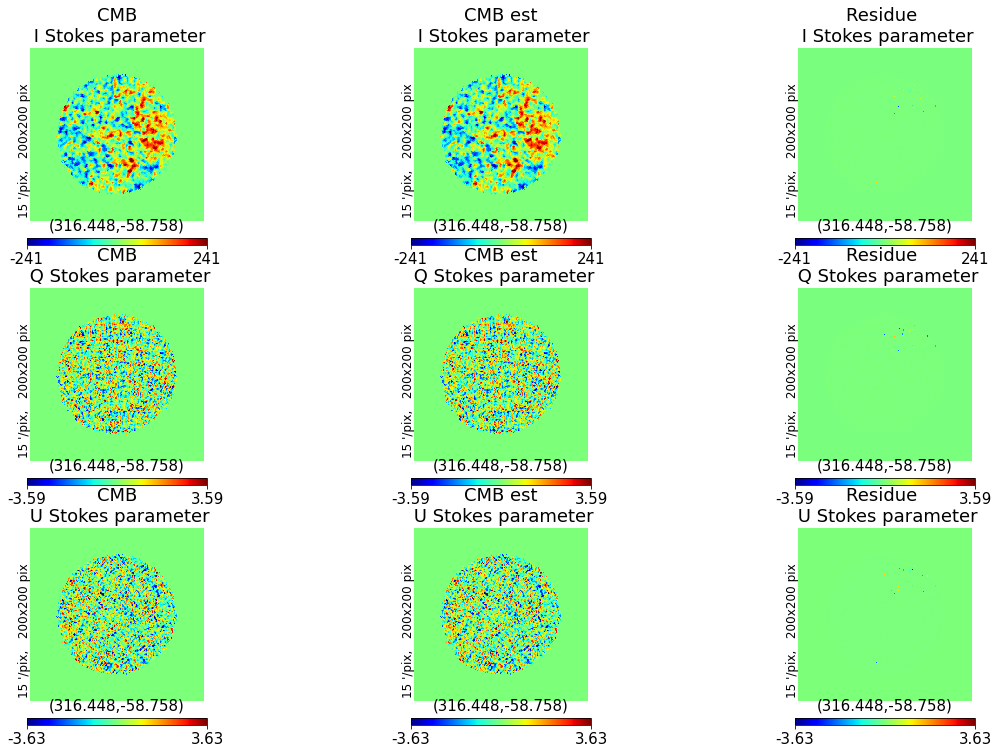

In [238]:
Plots.Plots.diff_2_maps(cmb_same_resol, array_est_fg[0], okpix_inside, 0, center, 15,
                                                                'CMB', 'CMB est', Stokesparameter = Stkp)

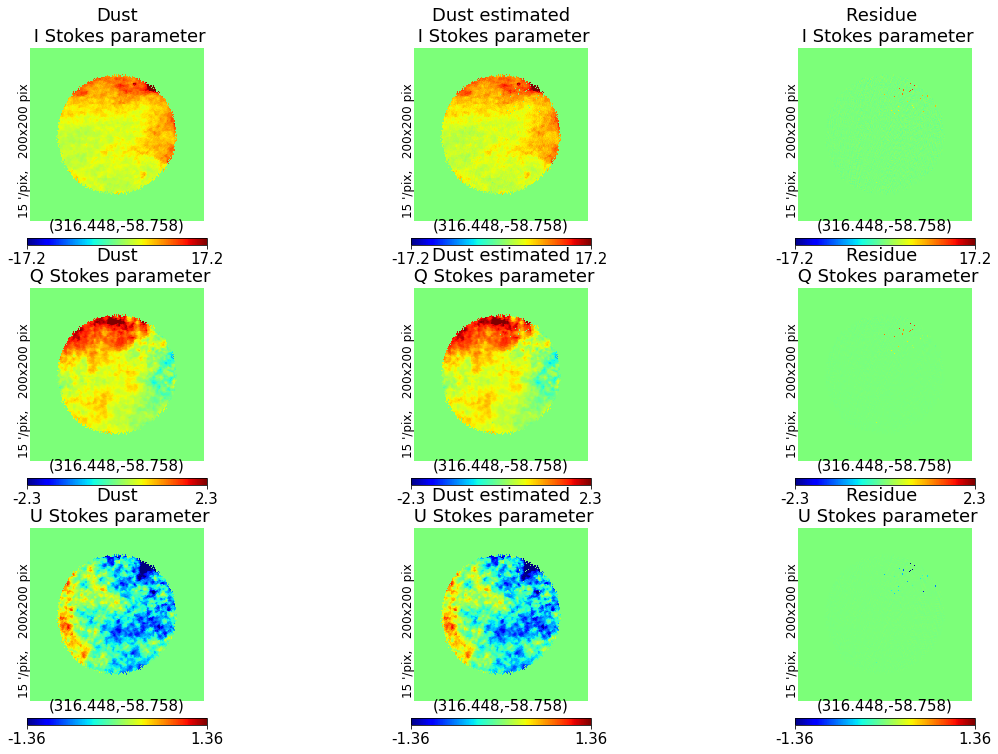

In [239]:
Plots.Plots.diff_2_maps(dust_same_resol, array_est_fg[1], okpix_inside, 0, center, 15, 
                                              'Dust', 'Dust estimated', Stokesparameter = Stkp)

To have a better idea of the quality of separation, we plot instensity histograms for all pixels seen by FG-Buster. In blue there is the theoretical map and in red the reconstruction.

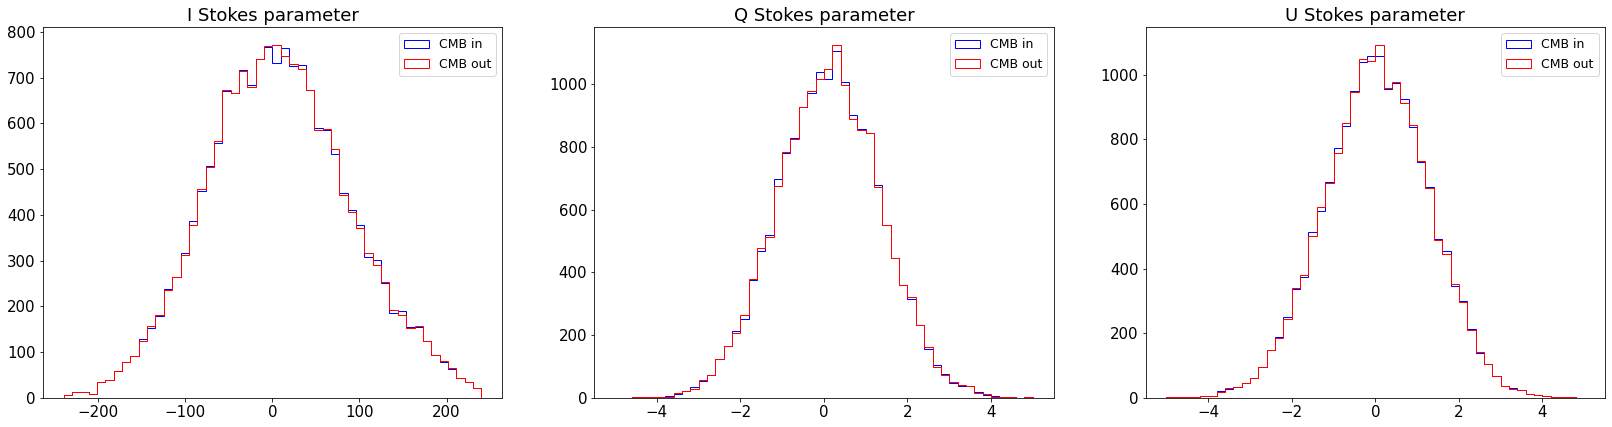

In [191]:
ranges = [[-240, 240], [-5, 5], [-5, 5]]
Plots.Plots.diff_2_hist(cmb_same_resol, array_est_fg[0], okpix_qubic, 2, 'CMB in', 'CMB out', 
                        ranges = ranges , bins = 50, Stokesparameter = Stkp)

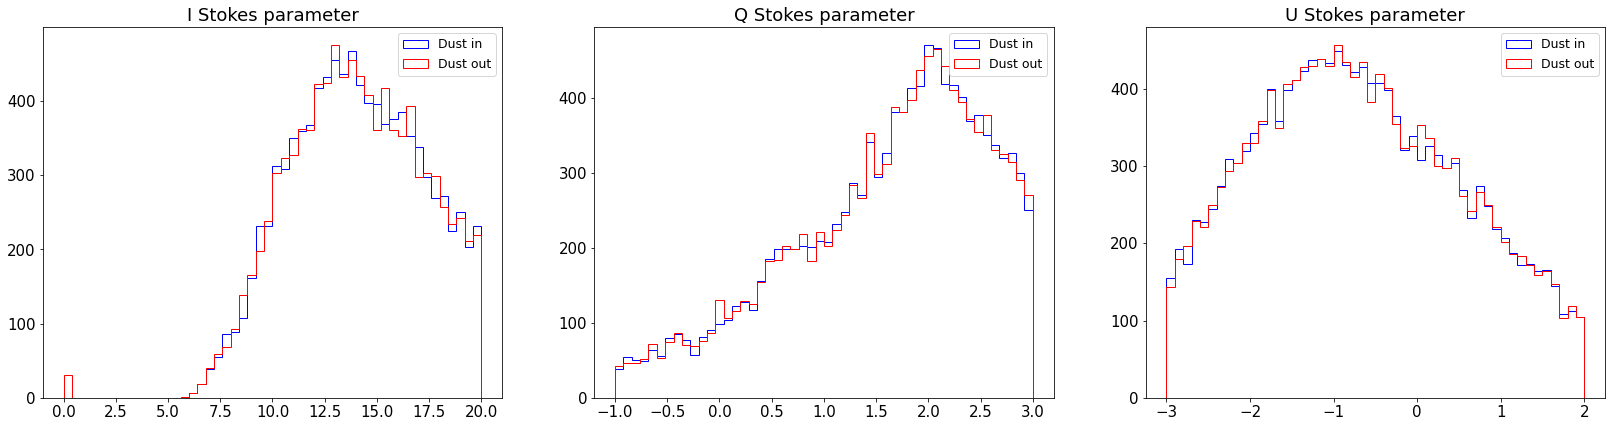

In [192]:
ranges = [[0, 20], [-1, 3], [-3, 2]]
Plots.Plots.diff_2_hist(dust_same_resol, array_est_fg[1], okpix_qubic, 2, 'Dust in', 'Dust out', 
                        ranges = ranges, bins = 50, Stokesparameter = Stkp)

# Power spectrum

input_ell shape =  (801,)
lmax= 511
(19,) (1, 19)


Text(0, 0.5, '$D_\\ell$')

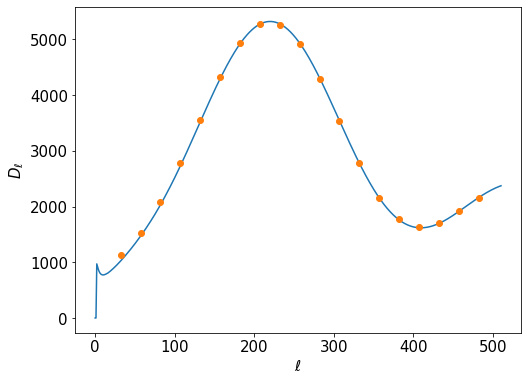

In [42]:
### Input Dls
input_Dl = Qubic_sky_150_cmb.input_cmb_spectra
if input_Dl is not None:
    input_ell = np.arange(np.shape(input_Dl)[0])
    print('input_ell shape = ', input_ell.shape)
    
# Create a Namaster object
lmin = 20
lmax = 2 * d150['nside'] - 1
delta_ell = 25

### Making mask - it will be automaticall apodized when instanciating the object with default (tunable) parameters
mask = np.zeros(12 * d150['nside']**2)
mask[okpix_inside] = 1

Namaster = nam.Namaster(mask, lmin=lmin, lmax=lmax, delta_ell=delta_ell)

ell_binned, b = Namaster.get_binning(d150['nside'])

Dls_binned = Namaster.bin_spectra(input_Dl[:, 0], d150['nside'])
print('lmax=', lmax)

print(ell_binned.shape, Dls_binned.shape)

plt.rc('figure', figsize=(8, 6))
plt.figure()
plt.plot(input_ell[:lmax], input_Dl[:lmax, 0])
plt.plot(ell_binned, Dls_binned[0, :],'o')
plt.xlabel('$\\ell$')
plt.ylabel('$D_\\ell$')

In [43]:
input_Dl = Qubic_sky_150_cmb.input_cmb_spectra
input_map = Qubic_sky_150_cmb.input_cmb_maps

In [44]:
lmax = 2 * d150['nside'] - 1
seenpix = (cov_qubic > (0.1*np.max(cov_qubic)))
mask = np.zeros(12 * d150['nside']**2)
mask[seenpix] = 1

# Namaster object
        
Namaster = nam.Namaster(mask, lmin=lmin, lmax=lmax, delta_ell=delta_ell)
ell_binned, b = Namaster.get_binning(d150['nside'])
Dls_binned = Namaster.bin_spectra(input_Dl[:, 0], d150['nside'])

In [45]:
# Get spectra
leff_cmb_est, cells_cmb_est, w_cmb_est = Namaster.get_spectra(array_est_fg[0][indf], purify_e=False, purify_b=True, 
                                        beam_correction = fwhm_final, pixwin_correction=None)

Getting TT, EE, BB, TE spectra in that order.


In [46]:
# Get spectra
leff_cmb, cells_cmb, w_cmb = Namaster.get_spectra(cmb_same_resol[indf], purify_e=False, purify_b=True, 
                                        beam_correction = fwhm_final, pixwin_correction=None)

Getting TT, EE, BB, TE spectra in that order.


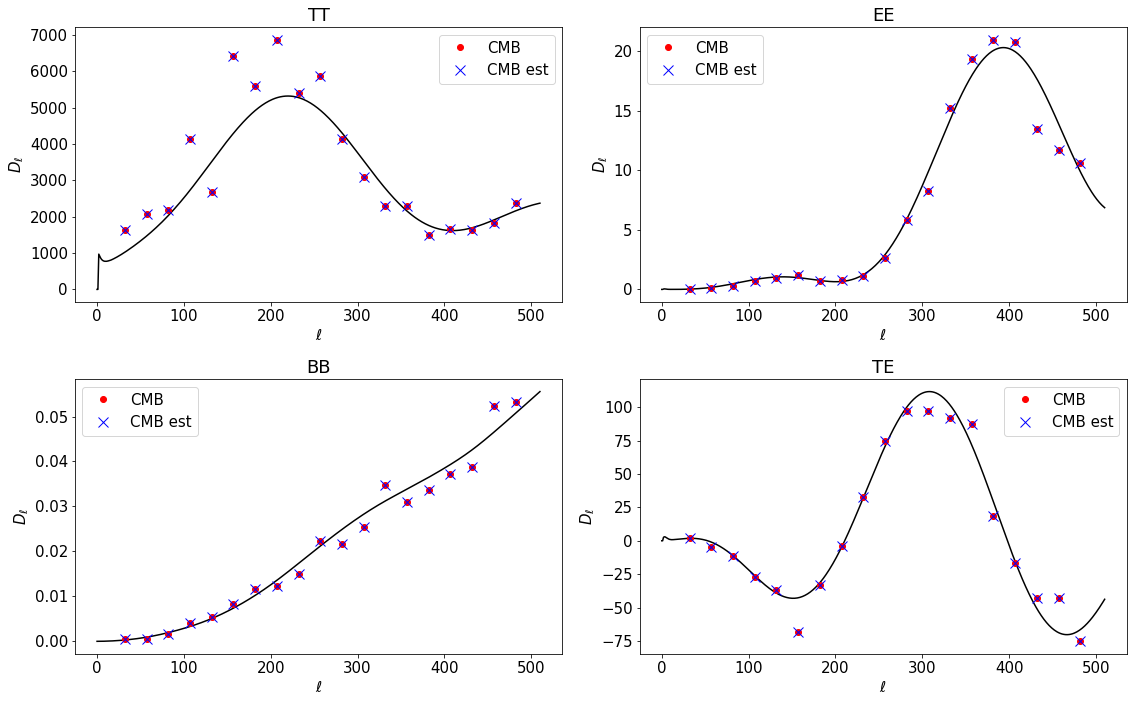

In [47]:
clnames = ['TT', 'EE', 'BB', 'TE']
s = 2
plt.rc('figure', figsize=(16, 10))
plt.figure()

for i in range(4) :
    plt.subplot(2, 2, i+1)
    plt.plot(input_ell[:lmax], input_Dl[:lmax, i], '-k')
    plt.plot(leff_cmb[:lmax], cells_cmb[:lmax, i],'or', label = 'CMB', markersize = 6)
    plt.plot(leff_cmb_est[:lmax], cells_cmb_est[:lmax, i],'xb', label = 'CMB est', markersize = 10)
    #plt.plot(leff, cls[2,0,:,s], 'xg', label='{}x{}'.format(2, 0), markersize = 10)
    plt.xlabel('$\\ell$')
    plt.ylabel('$D_\\ell$')
    plt.title(clnames[i])
    plt.legend()
plt.tight_layout()

# Monte-Carlo

In [73]:
reload(ComponentSeparation)

<module 'ComponentSeparation' from '/home/mathias/Bureau/ComponentSeparation.py'>

In [90]:
nsim = 20
cl_cmb = []
cl_dust = []
cl_cmb_est = []
cl_dust_est = []
Rx = []
indf = 0
Stkp = 'IQU'
okpix_maps = okpix_inside.copy()

In [91]:
cmbdust = []
cmb = []
dust = []

for i in range(nsim) :
    seed = i
    sky_config = {'dust' : 'd0', 'cmb': seed}
    Qubic_sky_150 = qss.Qubic_sky(sky_config, d150)

    CMBdust, CMBdust_noiseless, CMBdust_noise, P = Qubic_sky_150.get_partial_sky_maps_withnoise(coverage=cov150,
                                       Nyears=nyears, verbose=False, FWHMdeg=FWHMdeg, seed = seed,
                                       spatial_noise=spatial_noise,
                                       nunu_correlation=nunu_correlation,
                                       integrate_into_band=integration_into_band
                                                )
    CMBdust = np.transpose(CMBdust, (0, 2, 1))
    
    cmbdust.append(CMBdust)
    
    sky_config = {'cmb': seed}
    Qubic_sky_150_cmb = qss.Qubic_sky(sky_config, d150)
    
    # CMB only
    maps_cmb, CMB_noiseless, CMB_noise, P = Qubic_sky_150_cmb.get_partial_sky_maps_withnoise(coverage=cov150,
                                       Nyears=nyears, verbose=False, FWHMdeg=FWHMdeg, seed = seed,
                                       spatial_noise=spatial_noise,
                                       nunu_correlation=nunu_correlation,
                                       integrate_into_band=integration_into_band
                                                )
    maps_cmb = np.transpose(maps_cmb, (0, 2, 1))
    
    sky_config = {'dust': 'd0'}
    Qubic_sky_150_dust = qss.Qubic_sky(sky_config, d150)
    
    # Dust only
    maps_dust, dust_noiseless, dust_noise, P = Qubic_sky_150_dust.get_partial_sky_maps_withnoise(coverage=cov150,
                                       Nyears=nyears, verbose=False, FWHMdeg=FWHMdeg, seed = seed,
                                       spatial_noise=spatial_noise,
                                       nunu_correlation=nunu_correlation,
                                       integrate_into_band=integration_into_band
                                                )
    maps_dust = np.transpose(maps_dust, (0, 2, 1))
    
    
    
    
    cmb_same_resol, _, _ = ComponentSeparation.same_resol(maps_cmb, fwhmdegs, 
                                                                fwhm_target = fwhm_final, verbose=True)
    cmb.append(cmb_same_resol)
    
    dust_same_resol, _, _ = ComponentSeparation.same_resol(maps_dust, fwhmdegs, 
                                                                fwhm_target = fwhm_final, verbose=True)
    dust.append(dust_same_resol)

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/cPRqr51U8C
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/5U7W0B2sal
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/vJNZU6TmWt
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/9DkQvyVUfQ
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/uGGDkCAQbS
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/iKSdNYOoY0
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/2g9ThrGwed
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/JURrmZJXir
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/UMv7HFHMSB
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/VkvrAQ3lwZ
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/6acIJEhkig
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/58QPxEiFiY
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/6AGEdgvhkV
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/23dWvyqiGa
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/GoUpew19qK
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/CXA5sgYtOq
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/oPGeLfjwLX
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/rkGjcKb4Ro
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/5CuUBNpZe0
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/CMjmdst5u2
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/96kulTAsal
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/YfxQSVVrj0
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/SBjNyRcJ9e
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/EzBvY6WyfI
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/nkToS54t1f
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/FBvRnQyRmr
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/0Tm55iGZMp
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/zxjMmfSjjm
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/xnjJL7LXRD
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/bIG1U6UmB3
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/WyUpw5V8RY
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/FnnLT4nZTd
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/UuIQfyoOwS
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/HKeJ5HIDtP
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/xBFM1mjZ88
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/NigTO28CSZ
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/msyyyPFVZo
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/iR0bSjFynd
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/HpF2DJn7Vz
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/ibI0aFyiAQ
  warnings.warn(f"Access data from {full_path}")


doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
doing band 0 131.25 142.7186739566296
doing band 1 142.7186739566296 155.18948492143804
doing band 2 155.18948492143804 168.74999999999997
<_io.BufferedReader name='/home/mathias/Bureau/qubic/qubic/doc/FastSimulator/Data/DataFastSimulator_FI150_nfsub_3.pkl'>
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 t

In [92]:
for i in range(nsim) :
    
    array_est_fg = np.zeros((((2, nbands, 3, 12*d150['nside']**2))))
    
    for j in range(3) :
        R = ComponentSeparation.CompSep(d150).fg_buster(cmbdust[i], 
            [CMB(), Dust(freqs[j], temp = 20.)], freq = freqs, fwhmdeg = fwhmdegs, 
                                                target = fwhm_final, okpix = okpix_maps, Stokesparameter = Stkp)


        array_est_fg[0, j, :, okpix_maps] = R.s[0, :, :].T
        array_est_fg[1, j, :, okpix_maps] = R.s[1, :, :].T
    
    
    array_est_fg[0][:, :, ~okpix_qubic] = 0
    array_est_fg[1][:, :, ~okpix_qubic] = 0
    
    # Get spectra
    leff_cmb, cells_cmb, w_cmb_est = Namaster.get_spectra(cmb[i][indf], purify_e=False, purify_b=True, 
                                        beam_correction = fwhm_final, pixwin_correction=None)
    
    # Get spectra
    leff_dust, cells_dust, w_dust_est = Namaster.get_spectra(dust[i][indf], purify_e=False, purify_b=True, 
                                        beam_correction = fwhm_final, pixwin_correction=None)
    
    # Get spectra
    leff_cmb_est, cells_cmb_est, w_cmb_est = Namaster.get_spectra(array_est_fg[0, indf], purify_e=False, purify_b=True, 
                                        beam_correction = fwhm_final, pixwin_correction=None)
    
    # Get spectra
    leff_dust_est, cells_dust_est, w_dust_est = Namaster.get_spectra(array_est_fg[1, indf], purify_e=False, purify_b=True, 
                                        beam_correction = fwhm_final, pixwin_correction=None)
    
    cl_cmb.append(cells_cmb)
    cl_dust.append(cells_dust)
    
    cl_cmb_est.append(cells_cmb_est)
    cl_dust_est.append(cells_dust_est)

0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
Getting TT, EE, BB, TE spectra in that order.
Getting TT, EE, BB, TE spectra in that order.
Getting TT, EE, BB, TE spectra in that order.
Getting TT, EE, BB, TE spectra in that order.
0.4299926901 0.42999269


Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
Getting TT, EE, BB, TE spectra in that order.
Getting TT, EE, BB, TE spectra in that order.
Getting TT, EE, BB, TE spectra in that order.
Getting TT, EE, BB, TE spectra in that order.
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.3636

Getting TT, EE, BB, TE spectra in that order.
Getting TT, EE, BB, TE spectra in that order.
Getting TT, EE, BB, TE spectra in that order.
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
Getting TT, EE, BB, TE spectra in that order.
Getting TT, EE, BB, TE s

In [93]:
mean_cl_cmb_est = np.mean(cl_cmb_est, axis = 0)
error_cl_cmb_est = np.std(cl_cmb_est, axis = 0)
mean_cl_cmb = np.mean(cl_cmb, axis = 0)
error_cl_cmb = np.std(cl_cmb, axis = 0)

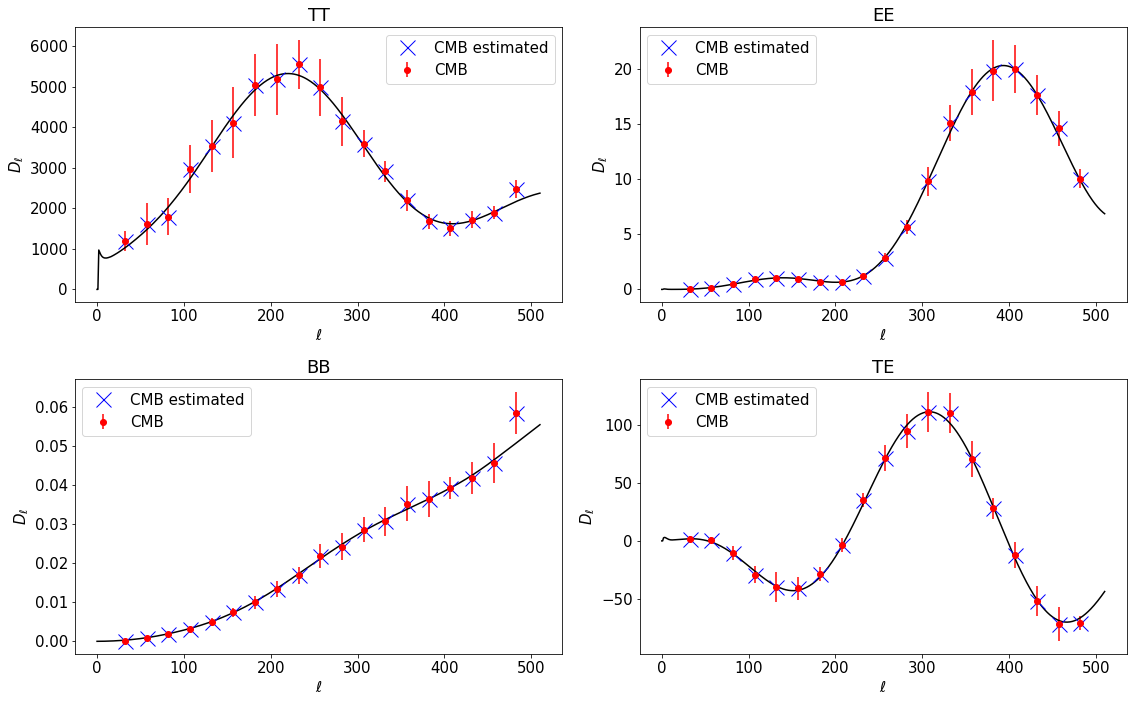

In [94]:
clnames = ['TT', 'EE', 'BB', 'TE']
plt.rc('figure', figsize=(16, 10))

for i in range(4) :
    plt.subplot(2, 2, i+1)
    plt.plot(input_ell[:lmax], input_Dl[:lmax, i], '-k')
    plt.plot(leff_cmb[:lmax], mean_cl_cmb_est[:lmax, i],'xb', label = 'CMB estimated', markersize = 15)
    plt.errorbar(leff_cmb[:lmax], mean_cl_cmb[:lmax, i], yerr=error_cl_cmb[:lmax,i], fmt='ro', label = 'CMB')
    #plt.plot(leff, cls[2,0,:,s], 'xg', label='{}x{}'.format(2, 0), markersize = 10)
    plt.xlabel('$\\ell$')
    plt.ylabel('$D_\\ell$')
    plt.title(clnames[i])
    plt.legend()
plt.tight_layout()

In [95]:
mean_cl_dust_est = np.mean(cl_dust_est, axis = 0)
error_cl_dust_est = np.std(cl_dust_est, axis = 0)
mean_cl_dust = np.mean(cl_dust, axis = 0)
error_cl_dust = np.std(cl_dust, axis = 0)

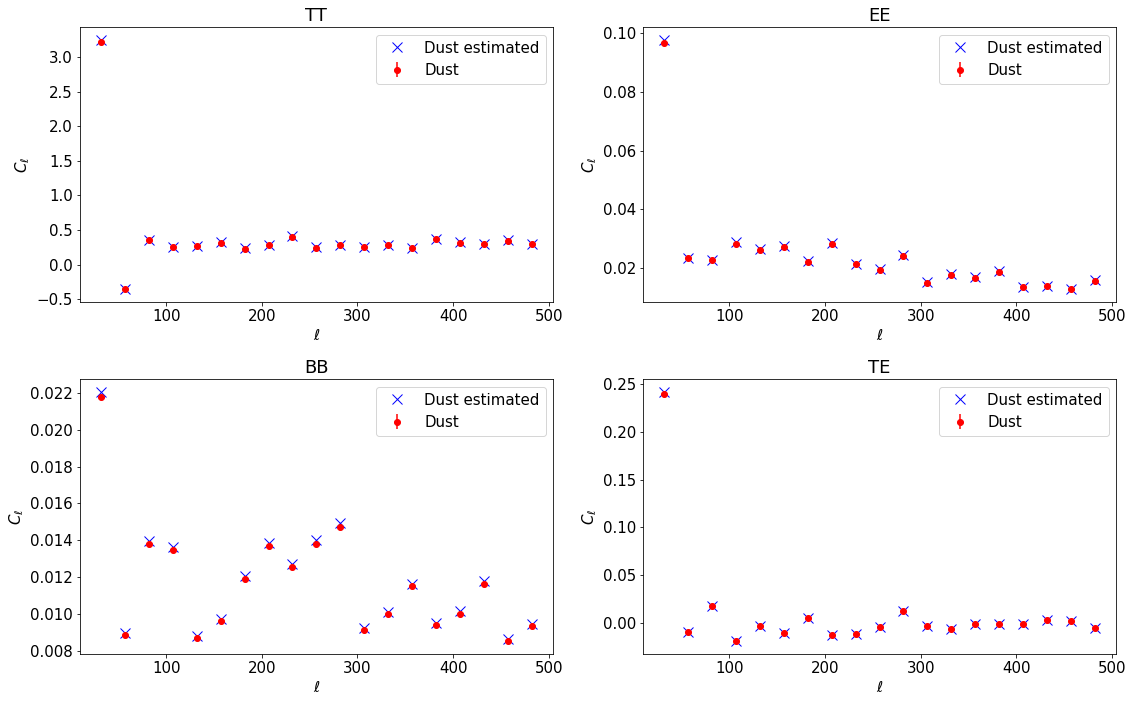

In [96]:
clnames = ['TT', 'EE', 'BB', 'TE']
plt.rc('figure', figsize=(16, 10))

for i in range(4) :
    plt.subplot(2, 2, i+1)
    plt.errorbar(leff_dust_est[:lmax], mean_cl_dust[:lmax, i], yerr=error_cl_dust[:lmax,i], fmt='ro', label = 'Dust')
    plt.plot(leff_dust_est, mean_cl_dust_est[:lmax, i], 'xb', label='Dust estimated', markersize = 10)
    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel('$\\ell$')
    plt.ylabel('$C_\\ell$')
    plt.title(clnames[i])
    plt.legend()
plt.tight_layout()

In [97]:
cl_cmbdust = []

for i in range(nsim) :
    
    print(i)
    
    cmbdust_same_resol, _, _ = ComponentSeparation.same_resol(cmbdust[i], fwhmdegs, 
                                                                fwhm_target = fwhm_final, verbose=True)
    
    # Get spectra
    leff_cmbdust, cells_cmbdust, w_cmbdust_est = Namaster.get_spectra(cmbdust_same_resol[indf], purify_e=False, purify_b=True, 
                                        beam_correction = fwhm_final, pixwin_correction=None)
    
    cl_cmbdust.append(cells_cmbdust)

0
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
Getting TT, EE, BB, TE spectra in that order.
1
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
Getting TT, EE, BB, TE spectra in that order.
2
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.429992690100
   -> Convolution with  0.00
Sub 1: Going from 0.395439080000 to 0.429992690100
   -> Convolution with  0.17
Sub 2: Going from 0.363662150000 to 0.429992690100
   -> Convolution with  0.23
Getting TT, EE, BB, TE spectra in that order.
3
0.4299926901 0.42999269
Sub 0: Going from 0.429992690000 to 0.

In [98]:
mean_cl_cmbdust = np.mean(cl_cmbdust, axis = 0)
error_cl_cmbdust = np.std(cl_cmbdust, axis = 0)

In [99]:
def power_law(x, a, b):
    return a*np.power(x, b)

In [100]:
alpha = []
beta = []
for i in range(4) :
    pars, cov = curve_fit(f=power_law, xdata=leff_cmb[:lmax], ydata=mean_cl_dust_est[:lmax, i], p0=[2, 2], bounds=(-50, 50))
    alpha.append(np.round(pars[1], 3))
    beta.append(np.round(pars[0], 3))

In [101]:
i = 2
ell = np.linspace(30, lmax, len(input_Dl[:lmax, i]))
model_dust = beta[i]*ell**alpha[i]
model_cmb = input_Dl[:lmax]

In [102]:
def Dl_2_Cl(Dl, l) :
    return Dl * 2 * np.pi / (l*(l+1))

def Cl_2_Dl(Cl, l) :
    return Cl * l*(l+1) / (2 * np.pi)

In [103]:
print(model_dust.shape)
print(model_cmb.shape)

(511,)
(511, 4)


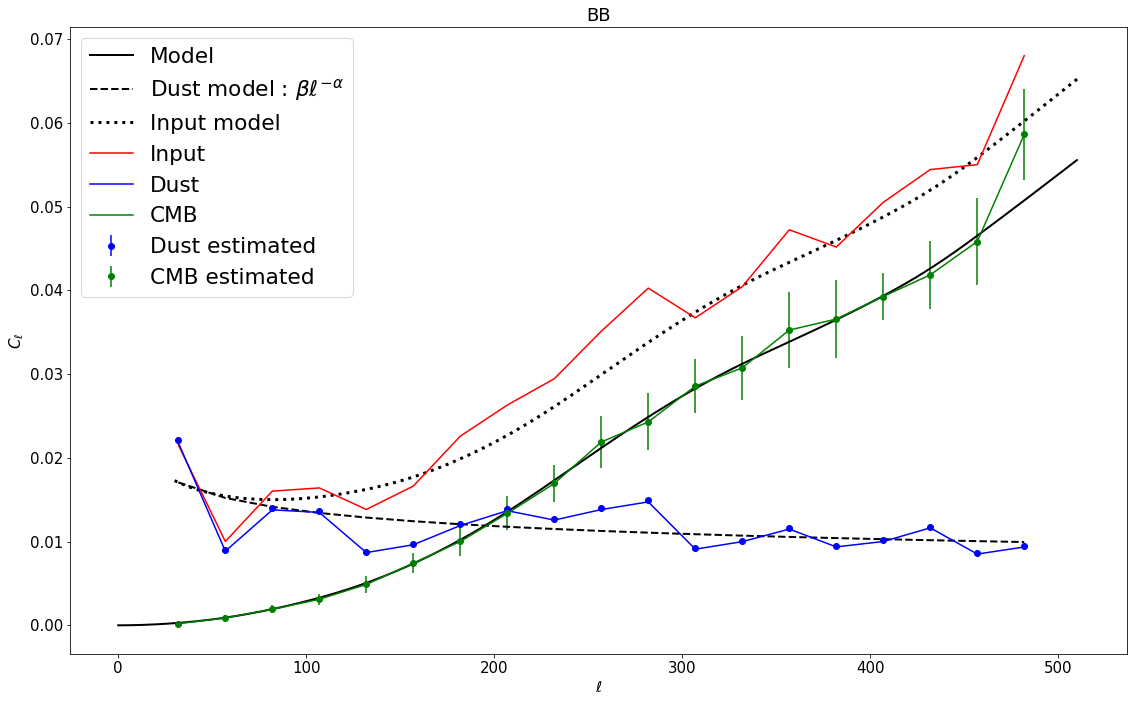

In [104]:
clnames = ['TT', 'EE', 'BB', 'TE']
plt.rc('figure', figsize=(16, 10))


plt.rc('figure', figsize = (16, 10))
#Models
plt.plot(input_ell[:lmax], input_Dl[:lmax, i], '-k', linewidth = 2, label = 'Model')
plt.plot(leff_cmb, beta[i] * leff_cmb**alpha[i], '--k', linewidth = 2, label=r'Dust model : $\beta \ell^{-\alpha}$', markersize = 10)
plt.plot(ell, model_dust + model_cmb[:lmax, i], ':k', linewidth = 3, label='Input model', markersize = 10)
#Maps
plt.plot(leff_dust_est, mean_cl_cmbdust[:lmax, i], '-r', label='Input', markersize = 10)
plt.plot(leff_dust_est, mean_cl_dust[:lmax, i], '-b', label='Dust', markersize = 10)
plt.plot(leff_dust_est, mean_cl_cmb[:lmax, i], '-g', label='CMB', markersize = 10)
#FG-Buster
plt.errorbar(leff_cmb[:lmax], mean_cl_dust_est[:lmax, i], yerr=error_cl_dust_est[:lmax,i], fmt='bo', label = 'Dust estimated')
plt.errorbar(leff_cmb[:lmax], mean_cl_cmb_est[:lmax, i], yerr=error_cl_cmb_est[:lmax,i], fmt='go', label = 'CMB estimated')

plt.xlabel('$\\ell$')
plt.ylabel('$C_\\ell$')
plt.title(clnames[i])
plt.legend(fontsize = 'x-large')
plt.tight_layout()